In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import hcp_utils as hcp
import nibabel as nib
import scipy.stats as ss
from numpy import genfromtxt    
from brainspace.datasets import load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
from brainspace.gradient.alignment import procrustes as pa
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt
from brainspace.gradient import GradientMaps
from brainspace.datasets import load_conte69
surf_lh, surf_rh = load_conte69()

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
intra_AI_mean = np.array(pd.read_csv('../data/data_results/gradient/mean_asym_LLRR.csv',header=None))
inter_AI_mean = np.array(pd.read_csv('../data/data_results/gradient/mean_asym_LRRL.csv',header=None))

In [3]:
glasser = genfromtxt('../data/glasser.csv')
ca = np.array(pd.read_csv('../data/ca_glasser_network.csv',header=None))[:,0].astype(float)
ca_l = ca[:180]
ca_r = ca[180:]

In [4]:
glasser_r = glasser[32492:]
glasser_l = glasser[:32492]
glasser_r[np.where(glasser_r == 180)] = 0

glasser_ll = np.concatenate((glasser_l,glasser_l))

labeling = glasser_ll.copy()

mymask = labeling != 0

## local-global issue

**connectivity difference**

In [5]:
path = '../data/data_results/FC/LL/'
path_list = os.listdir(path)
path_list.sort()
intra = np.zeros((len(path_list), 12))
LL = np.zeros((len(path_list), 12))
RR = np.zeros((len(path_list), 12))
for i in range(len(path_list)):
  data_l = np.loadtxt('../data/data_results/FC/LL/'+path_list[i], delimiter=',')
  data_r = np.loadtxt('../data/data_results/FC/RR/'+path_list[i], delimiter=',')
  for n in range(12):
    LL[i][n] = np.mean(data_l[ca_l==n+1][:,ca_l==n+1])
    RR[i][n] = np.mean(data_r[ca_r==n+1][:,ca_r==n+1])
    intra[i][n] = LL[i][n] - RR[i][n]

In [6]:
df = pd.DataFrame()
df['Connectivity'] = np.concatenate((LL.reshape(12168), RR.reshape(12168)))
df['Network'] = ['Vis1', 'Vis2', 'SMN', 'CON', 'DAN', 'Lan.', 
                 'FPN', 'Aud.', 'DMN', 'PMN', 'VMN', 'OAN'] * 1014 * 2
df['Hemisphere'] = np.concatenate((['Left'] * 12 * 1014, ['Right'] * 12 * 1014))                   

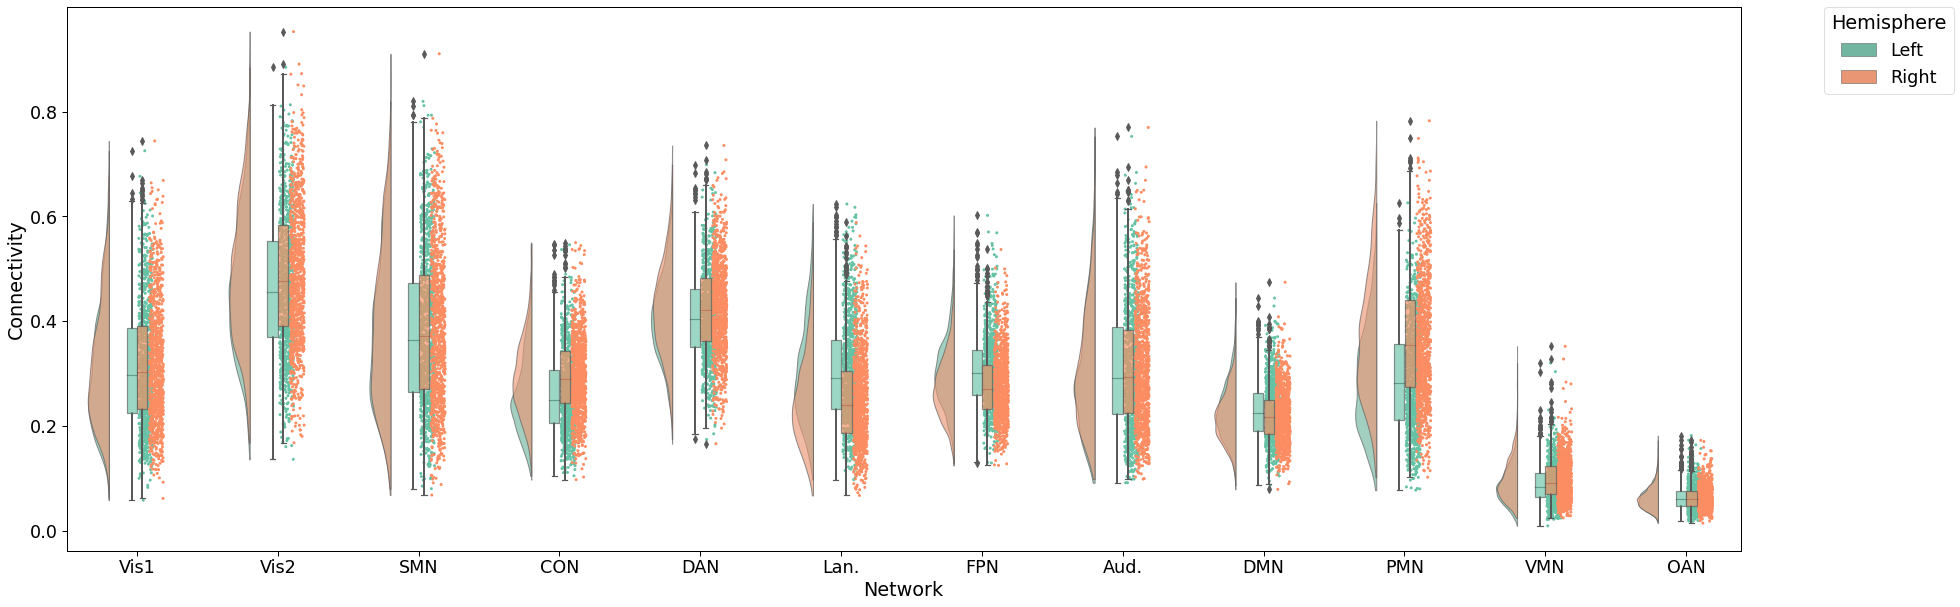

In [7]:
sns.set_context('paper', font_scale=2)

dx = 'Network'; dy = 'Connectivity'; dhue = 'Hemisphere'

fig, ax = plt.subplots(figsize=(30, 10))
ax=pt.RainCloud(x = dx, y = dy, data = df, width_viol = 0.3, hue = dhue, cut=0,
                ax = ax, alpha = 0.65, dodge = True, pointplot = False, move = .1)

plt.tight_layout
plt.savefig('../figures/response/connectivity_difference_intra.png', dpi=300)                

In [8]:
stat = [None] * 12
for i in range(12):
  stat[i] = ss.ttest_1samp(intra[:,i], 0)
stat

[Ttest_1sampResult(statistic=-5.202781582941497, pvalue=2.3756773794362543e-07),
 Ttest_1sampResult(statistic=-22.593500108843795, pvalue=7.446776540166369e-92),
 Ttest_1sampResult(statistic=-8.262006899700836, pvalue=4.448258067275346e-16),
 Ttest_1sampResult(statistic=-32.7145406918756, pvalue=8.767078961901913e-161),
 Ttest_1sampResult(statistic=-11.272145800869362, pvalue=7.571699312994849e-28),
 Ttest_1sampResult(statistic=33.827175381189605, pvalue=1.795128443358166e-168),
 Ttest_1sampResult(statistic=24.43930125529593, pvalue=4.564240509097542e-104),
 Ttest_1sampResult(statistic=0.19100259303117217, pvalue=0.8485618348),
 Ttest_1sampResult(statistic=11.303435835322556, pvalue=5.519365549855981e-28),
 Ttest_1sampResult(statistic=-35.71885679390706, pvalue=1.666784982191472e-181),
 Ttest_1sampResult(statistic=-11.056499227915221, pvalue=6.569834969043088e-27),
 Ttest_1sampResult(statistic=0.3111305029868577, pvalue=0.7557654253944017)]

([<matplotlib.axis.XTick at 0x7f4b72a1ad90>,
 [Text(-30, 0, 'Left'), Text(0, 0, 't-values'), Text(30, 0, 'Right')])

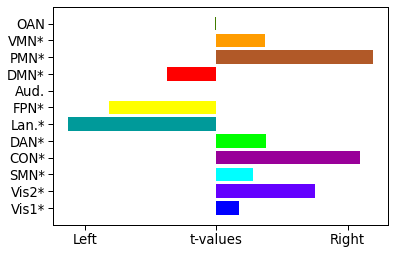

In [9]:
a = ['Vis1*', 'Vis2*', 'SMN*', 'CON*', 'DAN*', 'Lan.*', 'FPN*', 'Aud.', 'DMN*', 'PMN*', 'VMN*', 'OAN']
color = list(hcp.ca_network['rgba'].values())[1:]
sns.set_context('paper', font_scale=1.5)
plt.barh(a, -np.array(stat)[:,0], color = color)
plt.xticks([-30, 0, 30],['Left', 't-values', 'Right'])

## Vertex-wise

In [10]:
grad_ll = -np.loadtxt('../data/data_results/supplementary/vertex_wise/response/grad/group_grad_LL.txt')
grad_rr = np.loadtxt('../data/data_results/supplementary/vertex_wise/response/grad/group_grad_RR.txt')
grad_lr = np.loadtxt('../data/data_results/supplementary/vertex_wise/response/grad/group_grad_LR.txt')
grad_rl = np.loadtxt('../data/data_results/supplementary/vertex_wise/response/grad/group_grad_RL.txt')

In [11]:
wall = nib.freesurfer.io.read_annot('../data/medialwall.annot')[0]
grad_LL = np.zeros((32492, 10))
grad_LR = np.zeros((32492, 10))
grad_RR = np.zeros((32492, 10))
grad_RL = np.zeros((32492, 10))
for i in range(10):
  grad_LL[:,i][wall[:32492] == 1] = grad_ll[:,i]
  grad_LR[:,i][wall[:32492] == 1] = grad_lr[:,i]
  grad_RR[:,i][wall[32492:] == 1] = grad_rr[:,i]
  grad_RL[:,i][wall[32492:] == 1] = grad_rl[:,i]
grad_RR = pa(source=grad_RR, target=grad_LL)
grad_LR = pa(source=grad_LR, target=grad_LL)
grad_RL = pa(source=grad_RL, target=grad_LL)
grad_intra = grad_LL - grad_RR
grad_inter = grad_LR - grad_RL

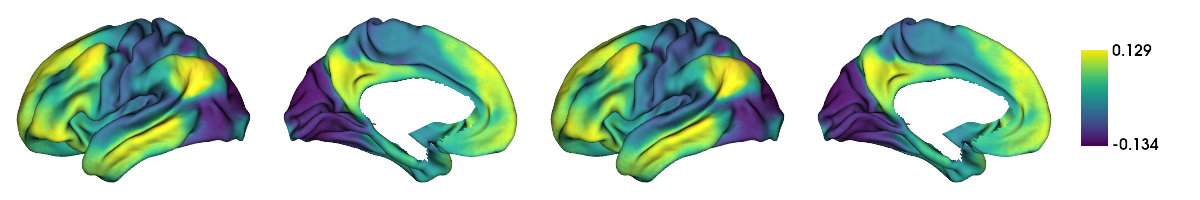

In [12]:
data=np.concatenate((grad_LL[:,0], grad_LL[:,0]))
data[labeling == 0] = np.nan
plot_hemispheres(surf_lh, surf_lh, array_name = data,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'viridis', color_bar = True, #color_range = (-0.3, 0.3),
                 interactive = False, zoom = 1.5, embed_nb = True)

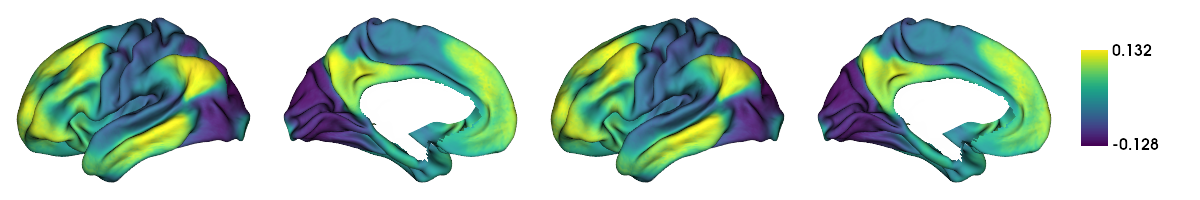

In [13]:
data=np.concatenate((grad_RR[:,0], grad_RR[:,0]))
data[labeling == 0] = np.nan
plot_hemispheres(surf_lh, surf_lh, array_name = data,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'viridis', color_bar = True, #color_range = (-0.25, 0.25),
                 interactive = False, zoom = 1.5, embed_nb = True)

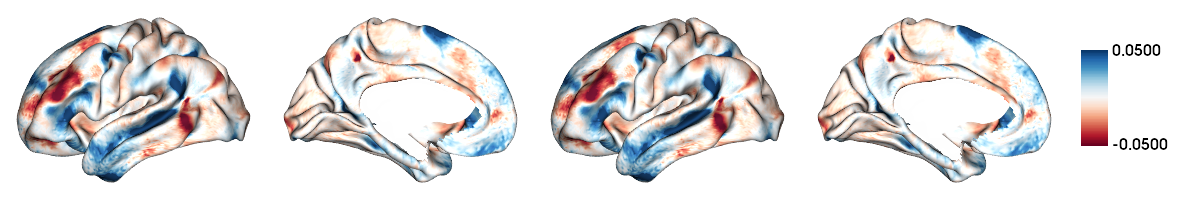

In [14]:
data=np.concatenate((grad_intra[:,0], grad_intra[:,0]))
data[labeling == 0] = np.nan
plot_hemispheres(surf_lh, surf_lh, array_name = data,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'RdBu', color_bar = True, color_range = (-0.05, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/response/intra_g1_vertex.png')
plot_hemispheres(surf_lh, surf_lh, array_name = data,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'RdBu', color_bar = True, color_range = (-0.05, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True)

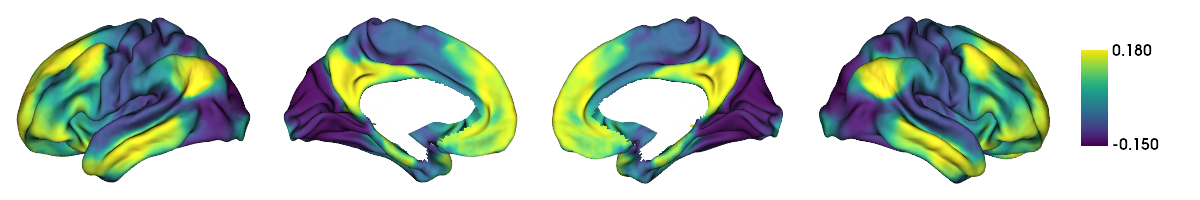

In [15]:
data=np.concatenate((grad_LR[:,0], grad_LR[:,0]))
data[labeling == 0] = np.nan
plot_hemispheres(surf_lh, surf_rh, array_name = data,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'viridis', color_bar = True, #color_range = (-0.25, 0.25),
                 interactive = False, zoom = 1.5, embed_nb = True)

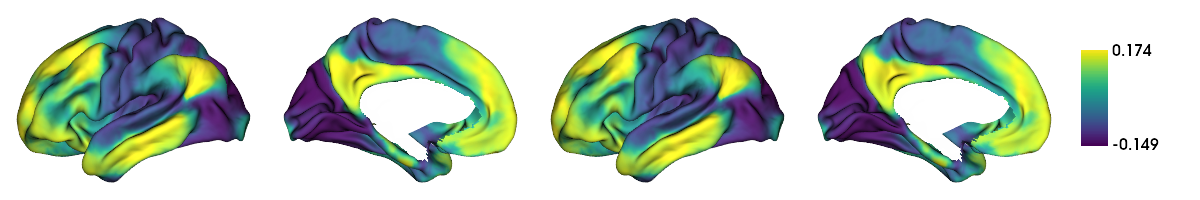

In [16]:
data=np.concatenate((grad_RL[:,0], grad_RL[:,0]))
data[labeling == 0] = np.nan
plot_hemispheres(surf_lh, surf_lh, array_name = data,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'viridis', color_bar = True, #color_range = (-0.25, 0.25),
                 interactive = False, zoom = 1.5, embed_nb = True)

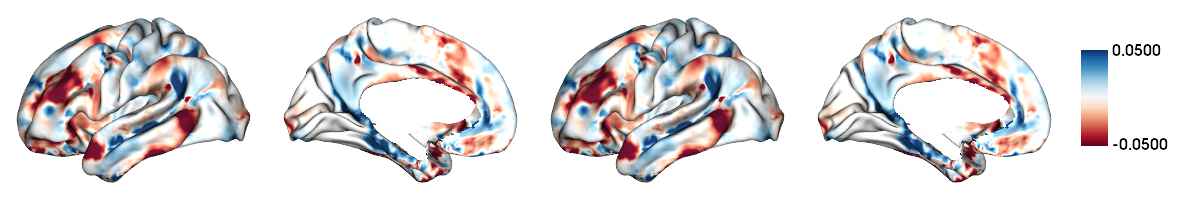

In [17]:
data=np.concatenate((grad_inter[:,0], grad_inter[:,0]))
data[labeling == 0] = np.nan
plot_hemispheres(surf_lh, surf_lh, array_name = data,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'RdBu', color_bar = True, color_range = (-0.05, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True, 
                 screenshot=True, filename='../figures/response/inter_g1_vertex.png')
plot_hemispheres(surf_lh, surf_lh, array_name = data,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'RdBu', color_bar = True, color_range = (-0.05, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True)

## pacel-size

In [18]:
parcel_l = np.array([len(glasser[:32492][glasser[:32492]==i+1]) for i in range(180)])
parcel_r = np.array([len(glasser[32492:][glasser[32492:]==i+181]) for i in range(180)])

In [19]:
def spin_human_spearman(x,y):
  # x, y should be one array 
  from brainspace.null_models import SampledSurrogateMaps
  n_surrogate_datasets = 1000

  # Note: number samples must be greater than number neighbors
  num_samples = 40
  num_neighbors = 20
  from scipy.sparse.csgraph import dijkstra
  distance= dijkstra(np.array(pd.read_csv('../data/LeftParcelGeodesicDistmat.txt',
                                          header=None, delimiter=' ')), directed=False)
  distance_idx_sorted = np.argsort(distance, axis=1)
  ssm = SampledSurrogateMaps(ns=num_samples, knn=num_samples, random_state=0,resample=True)
  ssm.fit(distance, distance_idx_sorted)
  x_surrogates = ssm.randomize(x, n_rep=n_surrogate_datasets)
  from brainsmash.mapgen.stats import spearmanr
  surrogate_corrs = spearmanr(y, x_surrogates).flatten()
  r_stat = spearmanr(x, y)[0]
  from brainsmash.mapgen.stats import nonparp
  p = nonparp(r_stat, surrogate_corrs)
  return print('spearmanr = '+ str(r_stat), 'p_value_spin = ', str(p))

def spin_human_pearson(x,y):
  # x, y should be one array 
  from brainspace.null_models import SampledSurrogateMaps
  n_surrogate_datasets = 1000

  # Note: number samples must be greater than number neighbors
  num_samples = 40
  num_neighbors = 20
  from scipy.sparse.csgraph import dijkstra
  distance= dijkstra(np.array(pd.read_csv('../data/LeftParcelGeodesicDistmat.txt',
                                          header=None, delimiter=' ')), directed=False)
  distance_idx_sorted = np.argsort(distance, axis=1)
  ssm = SampledSurrogateMaps(ns=num_samples, knn=num_samples, random_state=0,resample=True)
  ssm.fit(distance, distance_idx_sorted)
  x_surrogates = ssm.randomize(x, n_rep=n_surrogate_datasets)
  from brainsmash.mapgen.stats import pearsonr
  surrogate_corrs = pearsonr(y, x_surrogates).flatten()
  r_stat = pearsonr(x, y)[0]
  from brainsmash.mapgen.stats import nonparp
  p = nonparp(r_stat, surrogate_corrs)
  return print('pearsonr = '+ str(r_stat), 'p_value_spin = ', str(p))

In [20]:
[spin_human_spearman(intra_AI_mean[:,i], (parcel_l-parcel_r)/(parcel_l+parcel_r)) for i in range(3)]

spearmanr = [0.12983973] p_value_spin =  0.105
spearmanr = [0.00992111] p_value_spin =  0.905
spearmanr = [-0.01208888] p_value_spin =  0.881


[None, None, None]

In [21]:
[spin_human_spearman(inter_AI_mean[:,i], (parcel_l-parcel_r)/(parcel_l+parcel_r)) for i in range(3)]

spearmanr = [0.13007019] p_value_spin =  0.084
spearmanr = [-0.0025505] p_value_spin =  0.972
spearmanr = [-0.03349392] p_value_spin =  0.659


[None, None, None]

In [22]:
ll_fc = np.loadtxt('../data/data_results/FC/LL_groupmean.csv', delimiter=',')
rr_fc = np.loadtxt('../data/data_results/FC/RR_groupmean.csv', delimiter=',')

gm = GradientMaps(n_components=10, random_state=0, approach='dm', 
                  kernel='normalized_angle')
gm.fit(ll_fc)
gm_r = GradientMaps(n_components=10, random_state=0, approach='dm', 
                  kernel='normalized_angle')
gm_r.fit(rr_fc)
tmp = pa(source = gm_r.gradients_, target = gm.gradients_)
intra_pro = gm.gradients_ - tmp

gj = GradientMaps(n_components=10, random_state=0, approach='dm', 
                  kernel='normalized_angle', alignment='joint')
gj.fit([ll_fc, rr_fc])
intra_joint = gj.aligned_[0] - gj.aligned_[1]

In [23]:
spin_human_pearson(intra_joint[:,0], intra_pro[:,0])

pearsonr = [0.93049932] p_value_spin =  0.0


In [24]:
spin_human_pearson(intra_joint[:,1], intra_pro[:,1])

pearsonr = [0.96226233] p_value_spin =  0.0


In [25]:
spin_human_pearson(intra_joint[:,2], intra_pro[:,2])

pearsonr = [0.96226551] p_value_spin =  0.0


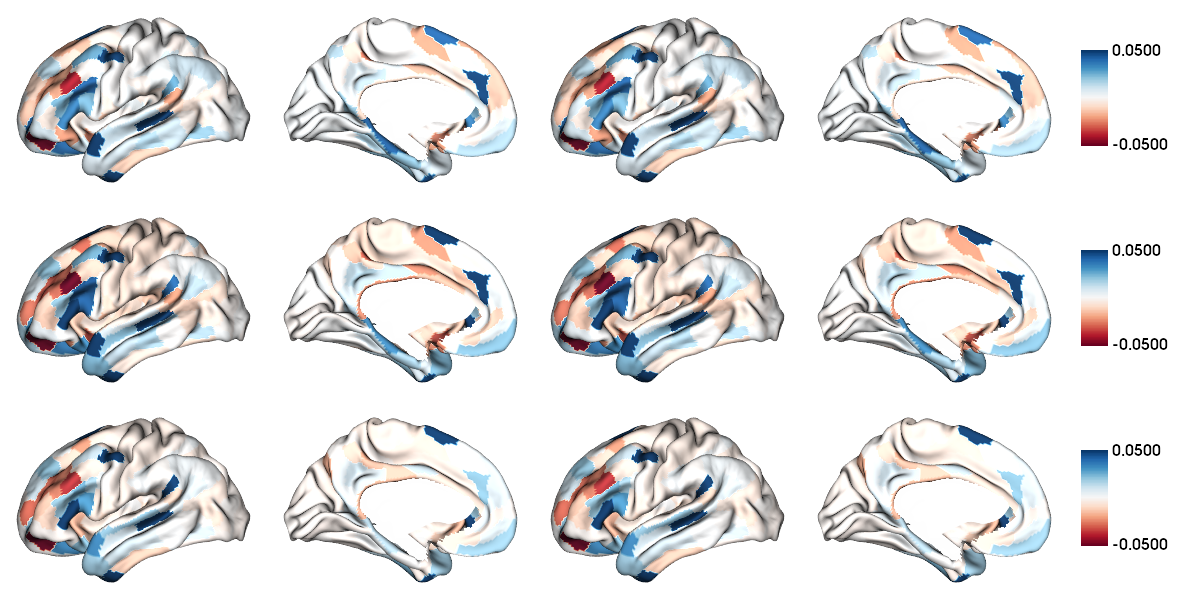

In [26]:
intra = [intra_joint[:,0], intra_pro[:,0], intra_AI_mean[:,0]]
data = [None] * len(intra)
for i in range(len(intra)):
  data[i] = map_to_labels(np.concatenate((intra[i], intra[i])), labeling, mask=mymask)
  data[i][data[i]==0] = np.nan
plot_hemispheres(surf_lh, surf_lh, array_name = data,
                 nan_color = (1,1,1,0.01),size = (1200, 200*len(intra)),
                 cmap = 'RdBu', color_bar = True, color_range = (-0.05, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/response/intra_joint_pro.png')

plot_hemispheres(surf_lh, surf_lh, array_name = data,
                 nan_color = (1,1,1,0.01),size = (1200, 200*len(intra)),
                 cmap = 'RdBu', color_bar = True, color_range = (-0.05, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True)

## G4-10

In [27]:
grad_intra = np.loadtxt('../data/data_results/gradient/mean_asym_LLRR.csv', delimiter=',')
grad_inter = np.loadtxt('../data/data_results/gradient/mean_asym_LRRL.csv', delimiter=',')

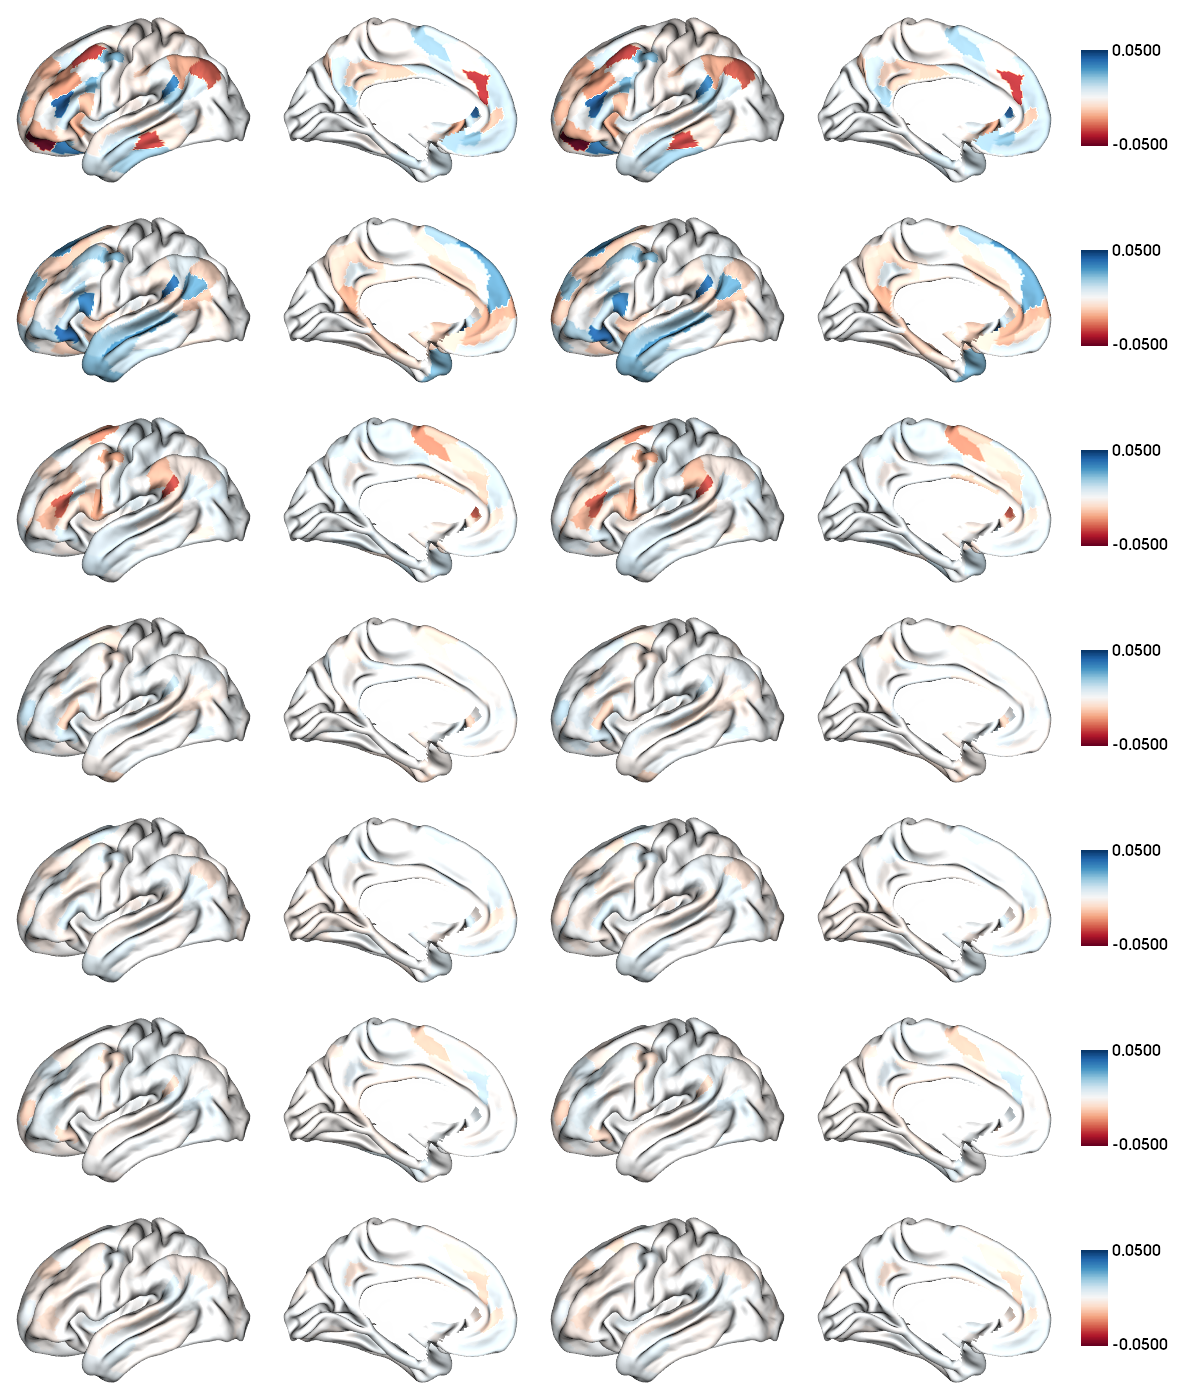

In [28]:
data = [None] * 7
for i in range(7):
  data[i] = map_to_labels(np.concatenate((grad_intra[:,i+3], grad_intra[:,i+3])), labeling, mask=mymask)
  data[i][data[i]==0] = np.nan
plot_hemispheres(surf_lh, surf_lh, array_name = data,
                 nan_color = (1,1,1,0.01),size = (1200, 200*7),
                 cmap = 'RdBu', color_bar = True, color_range = (-0.05, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/response/intra_mean_G4_10.png')

plot_hemispheres(surf_lh, surf_lh, array_name = data,
                 nan_color = (1,1,1,0.01),size = (1200, 200*7),
                 cmap = 'RdBu', color_bar = True, color_range = (-0.05, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True)

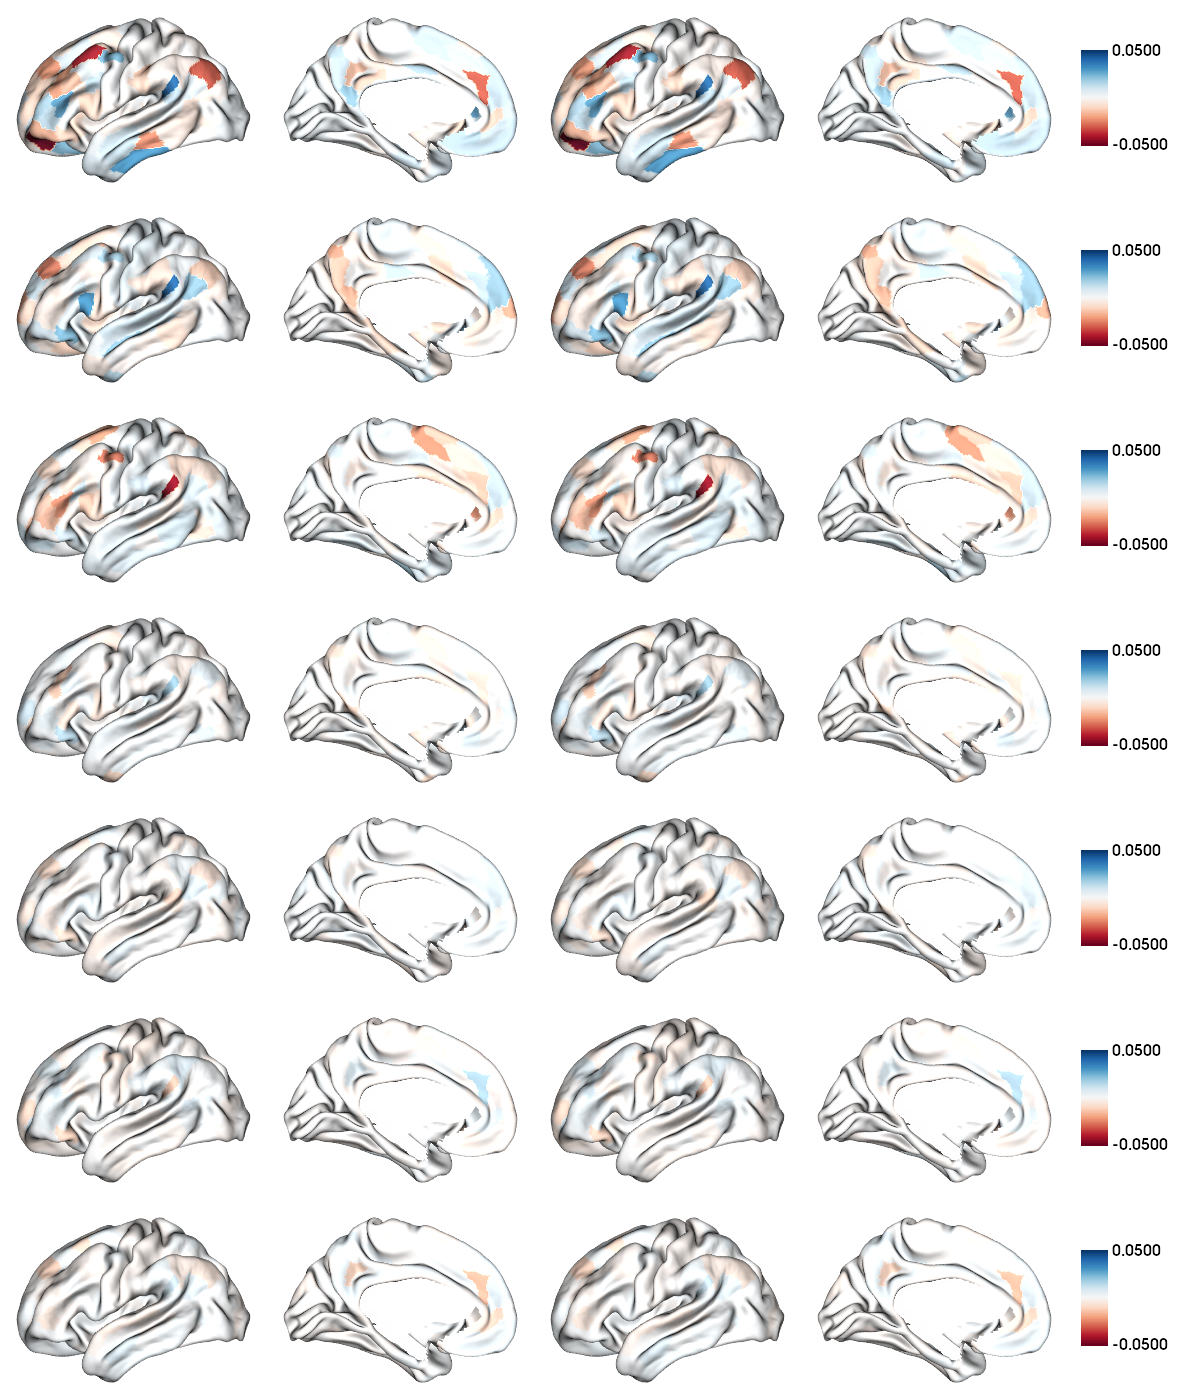

In [29]:
data = [None] * 7
for i in range(7):
  data[i] = map_to_labels(np.concatenate((grad_inter[:,i+3], grad_inter[:,i+3])), labeling, mask=mymask)
  data[i][data[i]==0] = np.nan
plot_hemispheres(surf_lh, surf_lh, array_name = data,
                 nan_color = (1,1,1,0.01),size = (1200, 200*7),
                 cmap = 'RdBu', color_bar = True, color_range = (-0.05, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/response/inter_mean_G4_10.png')

plot_hemispheres(surf_lh, surf_lh, array_name = data,
                 nan_color = (1,1,1,0.01),size = (1200, 200*7),
                 cmap = 'RdBu', color_bar = True, color_range = (-0.05, 0.05),
                 interactive = False, zoom = 1.5, embed_nb = True)

## RR processed by R1_rr_alignment.py

In [30]:
rr_explain = np.loadtxt('../data/data_results/supplementary/rr_align/grad/group_grad_RR_lambdas.csv')
rr_explain = rr_explain/rr_explain.sum()
rr_explain

array([0.22849706, 0.18754115, 0.15858015, 0.11426843, 0.07749665,
       0.0697579 , 0.05556629, 0.03920611, 0.03642608, 0.03266016])

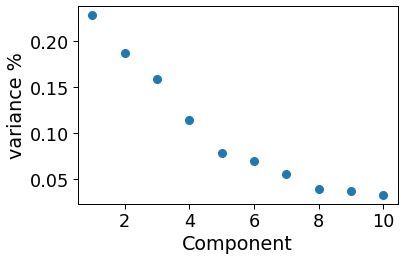

In [31]:
sns.set_context('paper', font_scale=2)
plt.plot(range(1,11), rr_explain, 'o', ms=8)
plt.xlabel('Component')
plt.ylabel('variance %')
plt.tight_layout()
plt.savefig('../figures/response/rr_explain.png')

In [32]:
intra_rr = np.loadtxt('../data/data_results/supplementary/rr_align/grad/mean_asym_LLRR.csv')
inter_rr = np.loadtxt('../data/data_results/supplementary/rr_align/grad/mean_asym_LRRL.csv')

In [33]:
[spin_human_pearson(intra_rr[:,i], grad_intra[:,i]) for i in range(3)]

pearsonr = [0.98935317] p_value_spin =  0.0
pearsonr = [0.93911534] p_value_spin =  0.0
pearsonr = [0.9865128] p_value_spin =  0.0


[None, None, None]

In [34]:
[spin_human_pearson(inter_rr[:,i], grad_inter[:,i]) for i in range(3)]

pearsonr = [0.97893204] p_value_spin =  0.0
pearsonr = [0.96031469] p_value_spin =  0.0
pearsonr = [0.98958565] p_value_spin =  0.0


[None, None, None]

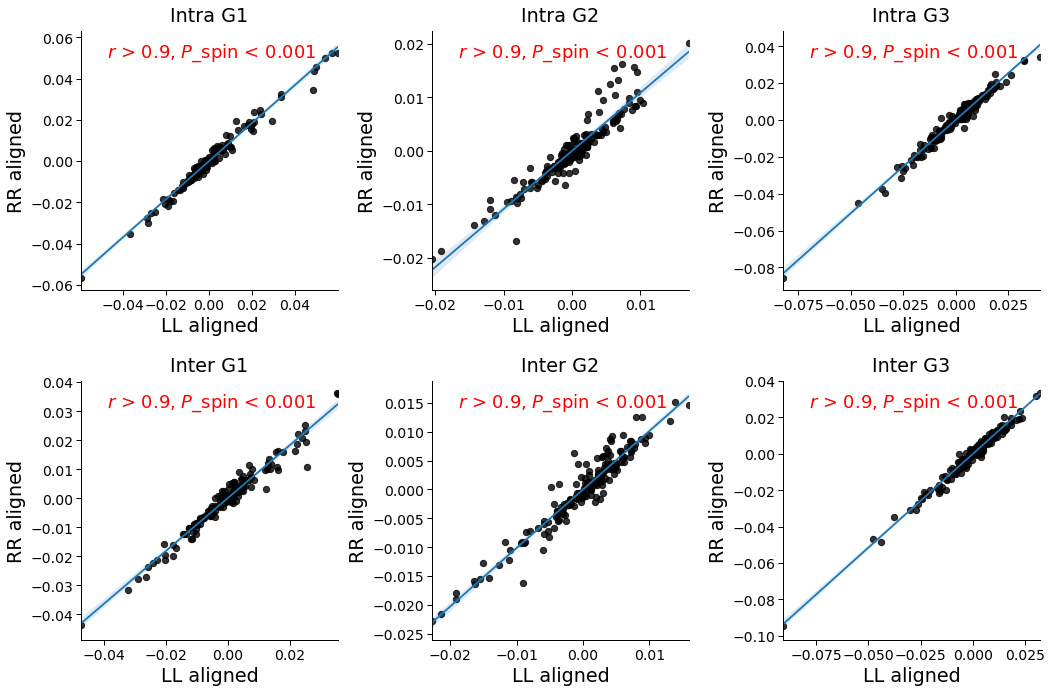

In [35]:
sns.set_context('paper', font_scale = 2)
fig, ax = plt.subplots(2,3, figsize=(15, 10))
ax = ax.ravel()
for i in range(6):
  if i < 3:  
    sns.regplot(grad_intra[:,i], intra_rr[:,i], ax = ax[i], scatter_kws={'s': 40, 'color': 'black'})
    ax[i].set_title('Intra G'+str(i+1), pad=10)
  else:
    sns.regplot(grad_inter[:,i-3], inter_rr[:,i-3], ax = ax[i], scatter_kws={'s': 40, 'color': 'black'})
    ax[i].set_title('Inter G'+str(i-2), pad=10)

  ax[i].tick_params(axis='both', labelsize=14)
  ax[i].spines['right'].set_visible(False)
  ax[i].spines['top'].set_visible(False)
  ax[i].text(0.1, 0.9, '$\it{r}$ > 0.9, $\it{P}$_spin < 0.001', fontsize=18, c='red', transform=ax[i].transAxes)      
  ax[i].set_xlabel('LL aligned')
  ax[i].set_ylabel('RR aligned')

fig.tight_layout()
plt.savefig('../figures/response/corr_ll_rr_align.png')

## cohen'd map

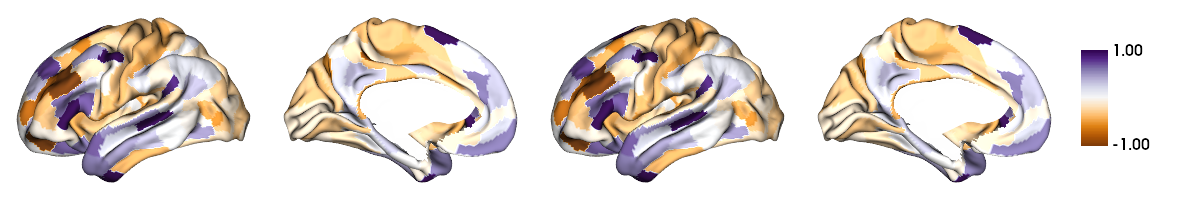

In [36]:
cohen = np.array(pd.read_csv('../data/data_results/gradient/intra_g1_stats.csv'))[:,1]/pow(1014, 0.5)
data = map_to_labels(np.concatenate((cohen, cohen)),
                          labeling, mask=mymask)
data[data==0] = np.nan
plot_hemispheres(surf_lh, surf_lh, array_name = data,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'PuOr', color_bar = True, color_range = (-1, 1),
                 interactive = False, zoom = 1.5, embed_nb = True, 
                 screenshot=True, filename='../figures/response/human_cohen_intra_g1.png')
plot_hemispheres(surf_lh, surf_lh, array_name = data,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'PuOr', color_bar = True, color_range = (-1, 1),
                 interactive = False, zoom = 1.5, embed_nb = True)

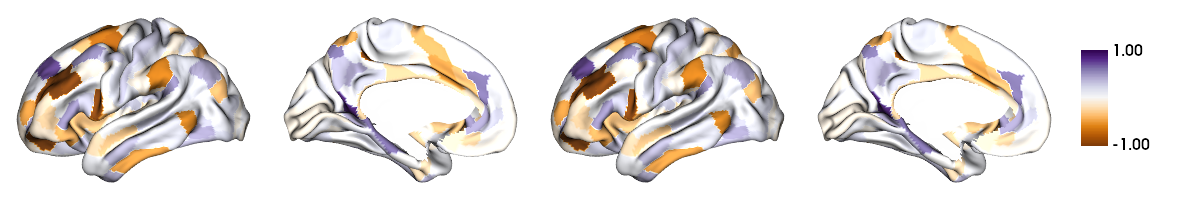

In [37]:
cohen = np.array(pd.read_csv('../data/data_results/gradient/inter_g1_stats.csv'))[:,1]/pow(1014, 0.5)
data = map_to_labels(np.concatenate((cohen, cohen)),
                          labeling, mask=mymask)
data[data==0] = np.nan
plot_hemispheres(surf_lh, surf_lh, array_name = data,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'PuOr', color_bar = True, color_range = (-1, 1),
                 interactive = False, zoom = 1.5, embed_nb = True, 
                 screenshot=True, filename='../figures/response/human_cohen_inter_g1.png')
plot_hemispheres(surf_lh, surf_lh, array_name = data,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'PuOr', color_bar = True, color_range = (-1, 1),
                 interactive = False, zoom = 1.5, embed_nb = True)

## correlation between mean gradients and group gradients

In [38]:
path = ('../data/data_results/gradient/LL/')
path_list = os.listdir(path)
path_list.sort()
ll = [None]*1014
rr = [None]*1014
lr = [None]*1014
rl = [None]*1014
for i in range(1014):
    ll[i] = np.array(pd.read_csv('../data/data_results/gradient/LL/'+path_list[i],header=None))
    rr[i] = np.array(pd.read_csv('../data/data_results/gradient/RR/'+path_list[i],header=None))
    lr[i] = np.array(pd.read_csv('../data/data_results/gradient/LR/'+path_list[i],header=None))
    rl[i] = np.array(pd.read_csv('../data/data_results/gradient/RL/'+path_list[i],header=None))

In [39]:
group_grad = np.loadtxt('../data/data_results/gradient/group_grad_LL.csv', delimiter=',')
ll_mean = np.array(ll).mean(axis=0)
rr_mean = np.array(rr).mean(axis=0)
lr_mean = np.array(lr).mean(axis=0)
rl_mean = np.array(rl).mean(axis=0)

In [40]:
[spin_human_spearman(ll_mean[:,i], group_grad[:,i]) for i in range(3)]

spearmanr = [0.98582878] p_value_spin =  0.0
spearmanr = [0.98802432] p_value_spin =  0.0
spearmanr = [0.97161641] p_value_spin =  0.0


[None, None, None]

In [41]:
[spin_human_spearman(rr_mean[:,i], group_grad[:,i]) for i in range(3)]

spearmanr = [0.97496631] p_value_spin =  0.0
spearmanr = [0.97785323] p_value_spin =  0.0
spearmanr = [0.94333776] p_value_spin =  0.0


[None, None, None]

In [42]:
[spin_human_spearman(lr_mean[:,i], group_grad[:,i]) for i in range(3)]

spearmanr = [0.97935739] p_value_spin =  0.0
spearmanr = [0.98274844] p_value_spin =  0.0
spearmanr = [0.96447421] p_value_spin =  0.0


[None, None, None]

In [43]:
[spin_human_spearman(rl_mean[:,i], group_grad[:,i]) for i in range(3)]

spearmanr = [0.97780384] p_value_spin =  0.0
spearmanr = [0.9751803] p_value_spin =  0.0
spearmanr = [0.94771032] p_value_spin =  0.0


[None, None, None]

## Macaque
**using left and right averaged hemisphere**

In [44]:
from brainsmash.mapgen.stats import spearmanr
from brainsmash.mapgen.stats import pearsonr
def spin_macaque_spearman(x,y):
  # x, y should be one array 
  from brainspace.null_models import SampledSurrogateMaps
  n_surrogate_datasets = 1000

  # Note: number samples must be greater than number neighbors
  num_samples = 20
  num_neighbors = 10
  from scipy.sparse.csgraph import dijkstra
  distance= dijkstra(np.array(pd.read_csv('../data/geodis_markov_l.csv',header=None)), directed=False)
  distance_idx_sorted = np.argsort(distance, axis=1)
  ssm = SampledSurrogateMaps(ns=num_samples, knn=num_samples, random_state=0,resample=True)
  ssm.fit(distance, distance_idx_sorted)
  x_surrogates = ssm.randomize(x, n_rep=n_surrogate_datasets)
  surrogate_corrs = spearmanr(y, x_surrogates).flatten()
  r_stat = spearmanr(x, y)[0]
  from brainsmash.mapgen.stats import nonparp
  p = nonparp(r_stat, surrogate_corrs)
  return print('spearmanr = '+ str(r_stat), 'p_value_spin = ', str(p))

def spin_macaque_pearson(x,y):
  # x, y should be one array 
  from brainspace.null_models import SampledSurrogateMaps
  n_surrogate_datasets = 1000

  # Note: number samples must be greater than number neighbors
  num_samples = 20
  num_neighbors = 10
  from scipy.sparse.csgraph import dijkstra
  distance= dijkstra(np.array(pd.read_csv('../data/geodis_markov_l.csv',header=None)), directed=False)
  distance_idx_sorted = np.argsort(distance, axis=1)
  ssm = SampledSurrogateMaps(ns=num_samples, knn=num_samples, random_state=0,resample=True)
  ssm.fit(distance, distance_idx_sorted)
  x_surrogates = ssm.randomize(x, n_rep=n_surrogate_datasets)
  surrogate_corrs = pearsonr(y, x_surrogates).flatten()
  r_stat = pearsonr(x, y)[0]
  from brainsmash.mapgen.stats import nonparp
  p = nonparp(r_stat, surrogate_corrs)
  return print('pearsonr = '+ str(r_stat), 'p_value_spin = ', str(p))

In [45]:
cohen_intra_hm = np.concatenate((nib.load('../data/Ting/aligned_20210409/lh.cohen_LR_intra_human.human-to-monkey.32k_fs_LR.nii.gz').get_fdata()[:,0][:,0],
                 -nib.load('../data/Ting/aligned_20210409/rh.cohen_LR_intra_human.human-to-monkey.32k_fs_LR.nii.gz').get_fdata()[:,0][:,0]))
cohen_inter_hm = np.concatenate((nib.load('../data/Ting/aligned_20210409/lh.cohen_LR_inter_human.human-to-monkey.32k_fs_LR.nii.gz').get_fdata()[:,0][:,0],
                 -nib.load('../data/Ting/aligned_20210409/rh.cohen_LR_inter_human.human-to-monkey.32k_fs_LR.nii.gz').get_fdata()[:,0][:,0]))

In [46]:
markov = '../data/markov.csv'
markov = genfromtxt(markov)
labeling_l = markov[:32492]
labeling_r = markov[32492:]
mymask_l = labeling_l != 0         
mymask_r = labeling_r != 0  
macaque = pd.read_csv('../data/data_results/macaque/macaque_asymmetric_gradients_stats.csv')
macaque['intra_g1_d']=macaque['intra_g1_t']/pow(19, 0.5)
macaque['inter_g1_d']=macaque['inter_g1_t']/pow(19, 0.5)
macaque['intra_g2_d']=macaque['intra_g2_t']/pow(19, 0.5)
macaque['inter_g2_d']=macaque['inter_g2_t']/pow(19, 0.5)
macaque['intra_g3_d']=macaque['intra_g3_t']/pow(19, 0.5)
macaque['inter_g3_d']=macaque['inter_g3_t']/pow(19, 0.5)
intra_g1_m = np.concatenate((map_to_labels(macaque['intra_g1_d'], labeling_l, mask=mymask_l),
                             map_to_labels(macaque['intra_g1_d'], labeling_r, mask=mymask_r)))
inter_g1_m = np.concatenate((map_to_labels(macaque['inter_g1_d'], labeling_l, mask=mymask_l),
                             map_to_labels(macaque['inter_g1_d'], labeling_r, mask=mymask_r)))
intra_g2_m = np.concatenate((map_to_labels(macaque['intra_g2_d'], labeling_l, mask=mymask_l),
                             map_to_labels(macaque['intra_g2_d'], labeling_r, mask=mymask_r)))
inter_g2_m = np.concatenate((map_to_labels(macaque['inter_g2_d'], labeling_l, mask=mymask_l),
                             map_to_labels(macaque['inter_g2_d'], labeling_r, mask=mymask_r)))
intra_g3_m = np.concatenate((map_to_labels(macaque['intra_g3_d'], labeling_l, mask=mymask_l),
                             map_to_labels(macaque['intra_g3_d'], labeling_r, mask=mymask_r)))
inter_g3_m = np.concatenate((map_to_labels(macaque['inter_g3_d'], labeling_l, mask=mymask_l),
                             map_to_labels(macaque['inter_g3_d'], labeling_r, mask=mymask_r)))

In [47]:
x, y = cohen_intra_hm[:,0], intra_g1_m

newx = [None] * 91
newy = [None] * 91
for i in range(91):
    newx[i] = (np.mean(x[:32492][markov[:32492]==i+1]) \
               + np.mean(x[32492:][markov[32492:]==i+1]))/2
    newy[i] = (np.mean(y[:32492][markov[:32492]==i+1]) \
               + np.mean(y[32492:][markov[32492:]==i+1]))/2

[ss.spearmanr(np.array(newx),np.array(newy)),
 ss.pearsonr(np.array(newx),np.array(newy)),
 spin_macaque_spearman(np.array(newx),np.array(newy)),
 spin_macaque_pearson(np.array(newx),np.array(newy))]

spearmanr = [0.34062749] p_value_spin =  0.057
pearsonr = [0.3445125] p_value_spin =  0.03


[SpearmanrResult(correlation=0.3406274884535754, pvalue=0.0009536752432047483),
 (0.3445125048452316, 0.0008257971386694765),
 None,
 None]

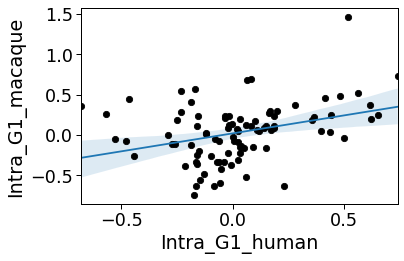

In [48]:
sns.set_context("paper", font_scale = 2)
f  = sns.regplot(newx,newy,scatter_kws={'s': 1})
f.scatter(newx, newy, s=40, c = 'black')
f.set_xlabel('Intra_G1_human')
f.set_ylabel('Intra_G1_macaque')
f.grid(False)
f=f.get_figure()
f.tight_layout()
f.savefig('../figures/response/fig_4_corr_intra_g1_g1.svg')

In [49]:
x, y = cohen_intra_hm[:,0], intra_g2_m

newx = [None] * 91
newy = [None] * 91
for i in range(91):
    newx[i] = (np.mean(x[:32492][markov[:32492]==i+1]) \
               + np.mean(x[32492:][markov[32492:]==i+1]))/2
    newy[i] = (np.mean(y[:32492][markov[:32492]==i+1]) \
               + np.mean(y[32492:][markov[32492:]==i+1]))/2

[ss.spearmanr(np.array(newx),np.array(newy)),
 ss.pearsonr(np.array(newx),np.array(newy)),
 spin_macaque_spearman(np.array(newx),np.array(newy)),
 spin_macaque_pearson(np.array(newx),np.array(newy))]

spearmanr = [-0.11651537] p_value_spin =  0.344
pearsonr = [-0.05552188] p_value_spin =  0.643


[SpearmanrResult(correlation=-0.11651536868928174, pvalue=0.27138795227095847),
 (-0.05552188114121898, 0.6011644274148186),
 None,
 None]

In [50]:
x, y = cohen_intra_hm[:,0], intra_g3_m

newx = [None] * 91
newy = [None] * 91
for i in range(91):
    newx[i] = (np.mean(x[:32492][markov[:32492]==i+1]) \
               + np.mean(x[32492:][markov[32492:]==i+1]))/2
    newy[i] = (np.mean(y[:32492][markov[:32492]==i+1]) \
               + np.mean(y[32492:][markov[32492:]==i+1]))/2

[ss.spearmanr(np.array(newx),np.array(newy)),
 spin_macaque_spearman(np.array(newx),np.array(newy))]

spearmanr = [-0.02468546] p_value_spin =  0.829


[SpearmanrResult(correlation=-0.024685459468068164, pvalue=0.8163326994685418),
 None]

In [51]:
x, y = cohen_inter_hm[:,0], inter_g1_m

newx = [None] * 91
newy = [None] * 91
for i in range(91):
    newx[i] = (np.mean(x[:32492][markov[:32492]==i+1]) \
               + np.mean(x[32492:][markov[32492:]==i+1]))/2
    newy[i] = (np.mean(y[:32492][markov[:32492]==i+1]) \
               + np.mean(y[32492:][markov[32492:]==i+1]))/2

[ss.spearmanr(np.array(newx),np.array(newy)),
 ss.pearsonr(np.array(newx),np.array(newy)),
 spin_macaque_spearman(np.array(newx),np.array(newy)),
 spin_macaque_pearson(np.array(newx),np.array(newy))]

spearmanr = [-0.06907151] p_value_spin =  0.648
pearsonr = [-0.02938709] p_value_spin =  0.858


[SpearmanrResult(correlation=-0.06907150820194298, pvalue=0.5153245659514756),
 (-0.02938708648714163, 0.7821492041602992),
 None,
 None]

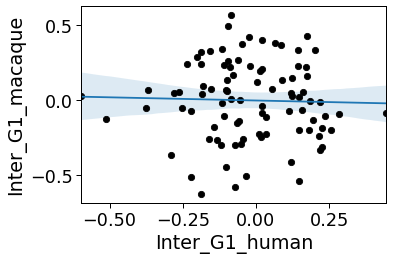

In [52]:
sns.set_context("paper", font_scale = 2)
f  = sns.regplot(newx,newy,scatter_kws={'s': 1})
f.scatter(newx, newy, s=40, c = 'black')
f.set_xlabel('Inter_G1_human')
f.set_ylabel('Inter_G1_macaque')
f.grid(False)
f=f.get_figure()
f.tight_layout()
f.savefig('../figures/response/fig_4_corr_inter_g1_g1.svg')

In [53]:
x, y = cohen_inter_hm[:,0], inter_g2_m

newx = [None] * 91
newy = [None] * 91
for i in range(91):
    newx[i] = (np.mean(x[:32492][markov[:32492]==i+1]) \
               + np.mean(x[32492:][markov[32492:]==i+1]))/2
    newy[i] = (np.mean(y[:32492][markov[:32492]==i+1]) \
               + np.mean(y[32492:][markov[32492:]==i+1]))/2

[ss.spearmanr(np.array(newx),np.array(newy)),
 ss.pearsonr(np.array(newx),np.array(newy)),
 spin_macaque_spearman(np.array(newx),np.array(newy)),
 spin_macaque_pearson(np.array(newx),np.array(newy))]

spearmanr = [-0.16150661] p_value_spin =  0.168
pearsonr = [-0.09424404] p_value_spin =  0.455


[SpearmanrResult(correlation=-0.16150660933269628, pvalue=0.12615627064768786),
 (-0.0942440361671545, 0.37422742664839276),
 None,
 None]

In [54]:
x, y = cohen_inter_hm[:,0], inter_g3_m

newx = [None] * 91
newy = [None] * 91
for i in range(91):
    newx[i] = (np.mean(x[:32492][markov[:32492]==i+1]) \
               + np.mean(x[32492:][markov[32492:]==i+1]))/2
    newy[i] = (np.mean(y[:32492][markov[:32492]==i+1]) \
               + np.mean(y[32492:][markov[32492:]==i+1]))/2

[ss.spearmanr(np.array(newx),np.array(newy)),
 spin_macaque_spearman(np.array(newx),np.array(newy))]

spearmanr = [0.12740882] p_value_spin =  0.243


[SpearmanrResult(correlation=0.12740882306099696, pvalue=0.22877785651882054),
 None]

In [55]:
from brainspace import mesh
macaque_rh = mesh.mesh_io.read_surface('../data/macaque_data/surf/spec/MacaqueYerkes19.R.inflated.32k_fs_LR.surf.gii')
macaque_lh = mesh.mesh_io.read_surface('../data/macaque_data/surf/spec/MacaqueYerkes19.L.inflated.32k_fs_LR.surf.gii')

In [56]:
markov = genfromtxt('../data/markov.csv')
markov_ll = np.concatenate((markov[:32492], markov[:32492]))
mask = markov_ll != 0

a = np.concatenate((nib.load('../data/Ting/Glasser2016_language/L.HCP_MMP_P210.human-to-monkey.32k_fs_LR.label.gii').agg_data(),
                    nib.load('../data/Ting/Glasser2016_language/R.HCP_MMP_P210.human-to-monkey.32k_fs_LR.label.gii').agg_data()))
ca = np.array(pd.read_csv('../data/ca_glasser_network.csv',header=None))[:,0].astype(float)

mask = a != 0
ca_macaque = map_to_labels(ca, a, mask=mask)
ca_macaque[ca_macaque==0]=np.nan

In [57]:
labels = ['Language','Default','Ventral-Multimodal','Primary Visual',
          'Secondary Visual','Somatomotor','Orbito-Affective','Dorsal-attention',
          'Posterior-Multimodal','Auditory','Cingulo-Opercular','Frontoparietal'][::-1]

color_h = [[0.      , 0.603922, 0.603922, 1.      ],
          [1., 0., 0., 1.],
          [1.      , 0.611765, 0.      , 1.      ],
          [0., 0., 1., 1.],
          [0.392157, 0.      , 1.      , 1.      ],
          [0., 1., 1., 1.],
          [0.254902, 0.486275, 0.      , 1.      ],
          [0., 1., 0., 1.],
          [0.694118, 0.34902 , 0.156863, 1.      ],
          [0.976471, 0.239216, 0.984314, 1.      ],
          [0.6, 0. , 0.6, 1. ],
          [1., 1., 0., 1.]][::-1]
color_m = [[0.      , 0.603922, 0.603922, 0.3      ],
          [1., 0., 0., 0.3],
          [1.      , 0.611765, 0.      , 0.3      ],
          [0., 0., 1., 0.3],
          [0.392157, 0.      , 1.      , 0.3      ],
          [0., 1., 1., 0.3],
          [0.254902, 0.486275, 0.      , 0.3      ],
          [0., 1., 0., 0.3],
          [0.694118, 0.34902 , 0.156863, 0.3      ],
          [0.976471, 0.239216, 0.984314, 0.3      ],
          [0.6, 0. , 0.6, 0.3 ],
          [1., 1., 0., 0.3]][::-1]

rank=[5,8,10,0,1,2,11,4,9,7,3,6]

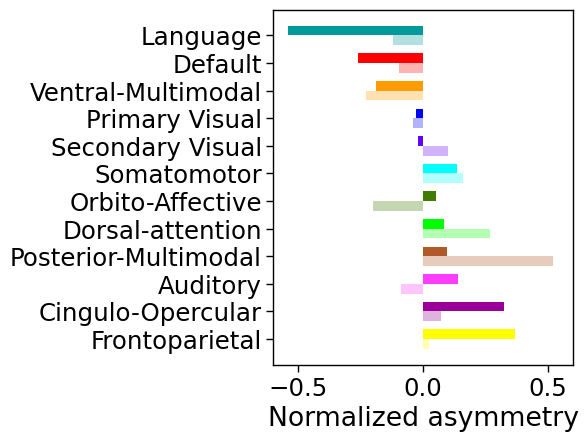

In [58]:
#intra

macaque_12 = [None] * 12
hm_12 = [None] * 12

for i in range(12):
    macaque_12[i] = -(np.mean(intra_g1_m[:32492][ca_macaque[:32492]==rank[i]+1][~np.isnan(intra_g1_m[:32492][ca_macaque[:32492]==rank[i]+1])]) + \
                      np.mean(intra_g1_m[32492:][ca_macaque[32492:]==rank[i]+1][~np.isnan(intra_g1_m[32492:][ca_macaque[32492:]==rank[i]+1])]))/2
    hm_12[i] = -(np.mean(cohen_intra_hm[:,0][:32492][ca_macaque[:32492]==rank[i]+1][~np.isnan(cohen_intra_hm[:,0][:32492][ca_macaque[:32492]==rank[i]+1])]) + \
                 np.mean(cohen_intra_hm[:,0][32492:][ca_macaque[32492:]==rank[i]+1][~np.isnan(cohen_intra_hm[:,0][:32492][ca_macaque[32492:]==rank[i]+1])]))/2

y = np.arange(len(labels))
width = 0.35
plt.rcdefaults()
sns.set_context("paper", font_scale = 2)
fig, ax = plt.subplots()
rects1 = ax.barh(y + width/2, hm_12[::-1], width, 
                 label='Humans',color=color_h)
rects2 = ax.barh(y - width/2, macaque_12[::-1], width, 
                 label='Macaques',color=color_m)
ax.set_xlabel('Normalized asymmetry')
ax.set_xlim(-0.6,0.6,0.3)
ax.set_yticks(y)
ax.set_yticklabels(labels)
#ax.yaxis.tick_right()
#ax.legend()

fig.tight_layout()
fig.savefig('../figures/response/fig_4_com_intra_g1.svg')

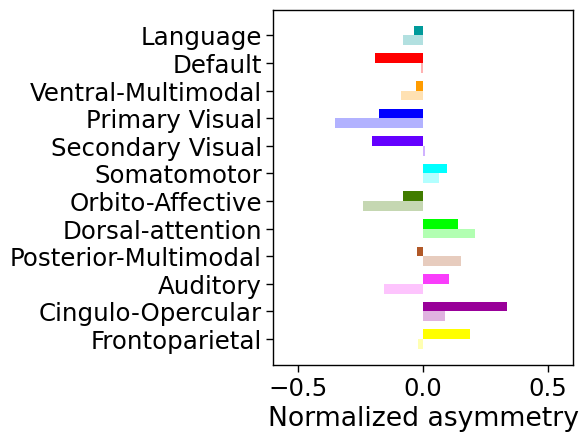

In [59]:
#intra

macaque_12 = [None] * 12
hm_12 = [None] * 12

for i in range(12):
    macaque_12[i] = -(np.mean(inter_g1_m[:32492][ca_macaque[:32492]==rank[i]+1][~np.isnan(inter_g1_m[:32492][ca_macaque[:32492]==rank[i]+1])]) + \
                      np.mean(inter_g1_m[32492:][ca_macaque[32492:]==rank[i]+1][~np.isnan(inter_g1_m[32492:][ca_macaque[32492:]==rank[i]+1])]))/2
    hm_12[i] = -(np.mean(cohen_inter_hm[:,0][:32492][ca_macaque[:32492]==rank[i]+1][~np.isnan(cohen_inter_hm[:,0][:32492][ca_macaque[:32492]==rank[i]+1])]) + \
                 np.mean(cohen_inter_hm[:,0][32492:][ca_macaque[32492:]==rank[i]+1][~np.isnan(cohen_inter_hm[:,0][:32492][ca_macaque[32492:]==rank[i]+1])]))/2

y = np.arange(len(labels))
width = 0.35
plt.rcdefaults()
sns.set_context("paper", font_scale = 2)
fig, ax = plt.subplots()
rects1 = ax.barh(y + width/2, hm_12[::-1], width, 
                 label='Humans',color=color_h)
rects2 = ax.barh(y - width/2, macaque_12[::-1], width, 
                 label='Macaques',color=color_m)
ax.set_xlabel('Normalized asymmetry')
ax.set_xlim(-0.6,0.6,0.3)
ax.set_yticks(y)
ax.set_yticklabels(labels)
#ax.yaxis.tick_right()
#ax.legend()

fig.tight_layout()
fig.savefig('../figures/response/fig_4_com_inter_g1.svg')

In [60]:
num = []
for i in range(10):
    num.append('asd')

In [61]:
num

['asd', 'asd', 'asd', 'asd', 'asd', 'asd', 'asd', 'asd', 'asd', 'asd']

In [62]:
dic = {'a': 1,
       'b': 2}

In [63]:
dic['b']

2